# CS 429: Information Retrieval

<br>

## Lecture 10: Query Expansion

<br>

### Dr. Aron Culotta
### Illinois Institute of Technology 


---

Last time:

- Evaluation
  - accuracy, precision, recall, MAP
  
This time:

- How can we incoporate user feedback to improve search?
- How can we alter the user's query to improve search?

# Relevance Feedback

- An *interactive* IR system in which 


1. The user enters a query.
2. The system returns results.
3. The user indicates which results are relevant.
4. GoTo 2.

# How should we incorporate user feedback?

- Create a new query that is similar to relevant documents but dissimilar to irrelevant documents.

# Rocchio

$ \DeclareMathOperator*{\argmax}{arg\,max}$
$\vec{q}^* \leftarrow \argmax_{\vec{q}} sim(\vec{q}, C_r) - sim(\vec{q}, C_{nr})$

- where $q$ is a query
- $C_r$ is a set of relevant documents
- $C_{nr}$ is a set of irrelevant documents
- $sim$ is cosine similarity

# Document Centroid

Recall that we represent each document as a vector of tf-idf values.

Given a collection of documents $D = \{\vec{d_1} \ldots \vec{d_N}\}$, the centroid vector is:

$$ \frac{1}{N} \sum_{\vec{d_j} \in D}\vec{d}_j $$

In [1]:
# A word about numpy arrays...
import numpy as np
a = [1,2,3]
b = [4,5,6]
print('list addition:', a + b)
print('numpy array addition:', np.array(a) + np.array(b))
print('numpy array division:', np.array(a) / 3)

list addition: [1, 2, 3, 4, 5, 6]
numpy array addition: [5 7 9]
numpy array division: [ 0.33333333  0.66666667  1.        ]


In [2]:
# list division? Nope.
a / 3

TypeError: unsupported operand type(s) for /: 'list' and 'int'

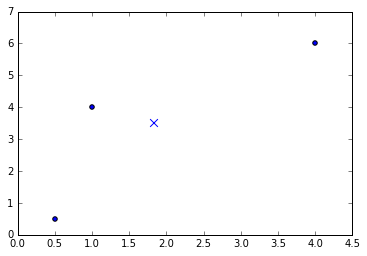

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

points = [[1, 4],
          [.5, .5],
          [4, 6]]

# Compute centroid.
centroid = np.sum(points, axis=0) / len(points)
plt.figure()
plt.scatter([p[0] for p in points],
            [p[1] for p in points])
plt.scatter([centroid[0]],
            [centroid[1]], marker='x', s=60)
plt.show()

Want a query that is closest to relevant documents, but far from irrelevant documents.

$$\vec{q}^* = \frac{1}{|C_r|} \sum_{\vec{d_j} \in C_r}\vec{d}_j - \frac{1}{|C_{nr}|} \sum_{\vec{d}_j \in C_{nr}} \vec{d}_j$$

![rocchio](files/rocchio.png)

Source: [MRS](http://nlp.stanford.edu/IR-book/pdf/09expand.pdf)

But, we don't know the set of all relevant and irrelevant documents.


$$\vec{q}_m = \alpha \vec{q}_0 + \beta\frac{1}{D_r} \sum_{\vec{d}_j \in D_r} \vec{d}_j - \gamma\frac{1}{|D_{nr}|} \sum_{\vec{d_j} \in D_{nr}} \vec{d}_j$$

- $\vec{q}_0$ is original query vector
- $\alpha$, $\beta$, $\gamma$ are tunable parameters.


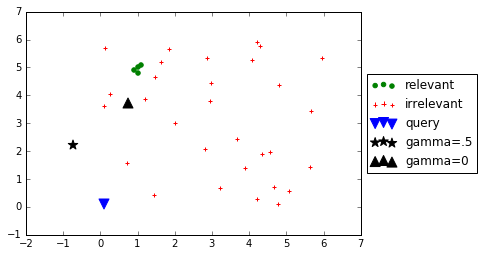

In [4]:
# Plot effect of relevance feedback as we change parameters.
import numpy as np
from numpy import array as npa
import random as rnd

def centroid(docs):
    return np.sum(docs, axis=0) / len(docs)

def rocchio(query, relevant, irrelevant, alpha, beta, gamma):
    return alpha * query + beta * centroid(relevant) - gamma * centroid(irrelevant) 

# Create some documents
relevant = npa([[1, 5], [1.1, 5.1], [0.9, 4.9], [1.0, 4.8]])
irrelevant = npa([[rnd.random()*6, rnd.random()*6] for i in range(30)])

# Create a query
query = npa([.1, .1])

# Compute two different Rocchio updates (gamma=0.5, gamma=0)
new_query_g5 = rocchio(query, relevant, irrelevant, 1., .75, .5)
new_query_g0 = rocchio(query, relevant, irrelevant, 1., .75, 0.)
new_query_g0_a0 = rocchio(query, relevant, irrelevant, 0., .75, 0.)

# Plot them.
plt.figure()
pos = plt.scatter([p[0] for p in relevant], [p[1] for p in relevant],
                  color='g', marker='o', label='relevant')
neg = plt.scatter([p[0] for p in irrelevant], [p[1] for p in irrelevant],
              marker='+', color='red', label='irrelevant')

q = plt.scatter(query[0], query[1], marker='v',
                color='b', s=100, label='query')
newq_b5 = plt.scatter([new_query_g5[0]], [new_query_g5[1]],
                      marker='*', s=100, color='black', label='gamma=.5')  # s=100, c=.9)
#newq_b0 = plt.scatter([new_query_g0[0]], [new_query_g0[1]],
#                      marker='d', s=100, color='black', label='gamma=0')  # s=100, c=.8)
newq_b0 = plt.scatter([new_query_g0_a0[0]], [new_query_g0_a0[1]],
                      marker='^', s=100, color='black', label='gamma=0')  # s=100, c=.8)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

- $\gamma=0$ Often used, since we're more confident in relevant annotations than irrelevant.

- One might decrease $\alpha$ as the number of relevant documents increase.

# Does relevance feedback help precision or recall?

- Mostly recall: "adding" similar terms to query vector from relevant documents.

- When would it not help?

- Spelling correction?
- Different language?
- Synonyms?


- Assumption 1: query is "close" to relevant documents
  - feedback makes the query closer
  
- Assumption 2: relevant documents form one cluster.

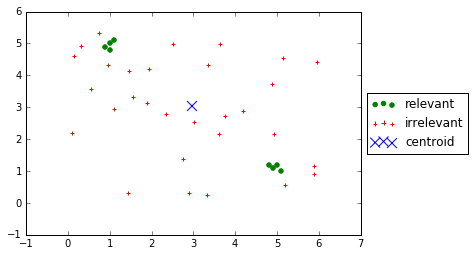

In [5]:
# What happens if there are two clusters of relevant examples?

import numpy as np
import random as rnd

points = [[1, 5], [1.1, 5.1], [0.9, 4.9], [1.0, 4.8],
          [5, 1.2], [4.9, 1.1], [5.1, 1.0], [4.8,1.2]]
plt.figure()
centroid = np.sum(points, axis=0) / len(points)
pos = plt.scatter([p[0] for p in points], [p[1] for p in points], 
                 color='green', label='relevant')
neg = plt.scatter([rnd.random()*6 for i in range(30)],
                  [rnd.random() * 6 for i in range(30)],
                  marker='+', color='red', label='irrelevant')
centroid = plt.scatter([centroid[0]], [centroid[1]],
                   marker='x', s=100, color='blue', label='centroid')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

*"If you have your one foot in a bucket of boiling hot water and another foot in a bucket of ice cold water, on average you ought to feel pretty comfortable."* --Unknown

# Does relevance feedback affect search time?

- Much longer queries
- How to approximate?
  - Use top $k$ most informative terms from relevant set.

# Variants of relevance feedback

- Pseudo-relevance: Assume top $k$ documents are relevant.
- Indirect relevance: Mine click logs.

# Pseudo-relevance feedback

1. Rank documents
2. Let $V$ be the top $k$ documents. We pretend these are all relevant.
3. Update $q$ according to Rocchio

We can iterate steps $2-3$ until ranking stops changing.

When would this work? When would this not work?

# Explicit query expansion

- Thesaurus
- Word co-occurrences
- Mine reformulations from query log

# WordNet

<http://wordnetweb.princeton.edu/perl/webwn>

---

<br><br><br><br><br>

# Thesaurus discovery

**Idea:** Look for words that occur in same context.

- "He put the mug on the \_\_\_\_\_"

- "He put his feet on the \_\_\_\_"

Query: "cheap tables" 
  - expand to include "affordable ottomans"

In [6]:
def get_context(tokens, position, window):
    """ Get tokens to the left and right of this position.
    Params:
      tokens.....list of strings in this sentence
      position...integer. index into tokens
      window.....integer. number of tokens to the left and right to consider.
    """
    start = max(position - window, 0)
    end = min(position + window + 1, len(tokens))
    left = ['L=%s' % x for x in tokens[start : position]]
    right = ['R=%s' % x for x in tokens[position + 1 : end]]
    return left + right
    
get_context(['a', 'b', 'c', 'd', 'e'], position=2, window=2)

['L=a', 'L=b', 'R=d', 'R=e']

In [7]:
from collections import Counter, defaultdict
from sklearn.datasets import fetch_20newsgroups
import re
docs = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes')).data
print('read', len(docs), 'docs')

read 11314 docs


In [8]:
# Count words that occur within a window of -n to +n of each word.
def term2contexts(docs, n):
    contexts = defaultdict(lambda: Counter())
    for d in docs:
        toks = re.findall('\w+', d.lower())
        for i in range(len(toks)):
            contexts[toks[i]].update(get_context(toks, i, n))
    return contexts

contexts = term2contexts(docs, n=2)
# Print top contexts for email
contexts['email'].most_common(10)

[('R=to', 112),
 ('L=please', 93),
 ('R=me', 86),
 ('R=address', 68),
 ('L=send', 60),
 ('L=by', 54),
 ('L=via', 49),
 ('R=the', 46),
 ('L=or', 44),
 ('R=and', 43)]

In [9]:
# NB: Efficiently incrementing a Counter using the .update method.
from collections import Counter
c = Counter()
c.update([1,2,1,1,3])
# versus (slow)
# c += Counter([1,2,1,1,3])
print(c)
c.update([3,3,3])
print(c)
print(c.most_common(2))

Counter({1: 3, 2: 1, 3: 1})
Counter({3: 4, 1: 3, 2: 1})
[(3, 4), (1, 3)]


In [10]:
print('made context vectors for %d terms' % len(contexts))
# Each word now has a "context vector" indicating
# the terms that often occur before/after it.

made context vectors for 101675 terms


In [11]:
contexts['believe'].most_common(10)

[('L=i', 492),
 ('R=that', 407),
 ('R=the', 248),
 ('L=to', 203),
 ('R=in', 188),
 ('L=t', 148),
 ('R=it', 138),
 ('L=you', 119),
 ('L=don', 103),
 ('L=do', 92)]

In [12]:
# Downweighting common terms with IDF.
# Compute inverse document frequency values for each term.
# Here: document frequency means how many different contexts this feature appears in.
import math
def compute_idfs(contexts):
    idfs = Counter()
    for term, context in contexts.items():
        idfs.update(context.keys())
    for d in idfs:
        idfs[d] = math.log10(len(contexts) / idfs[d])
    return idfs

idfs = compute_idfs(contexts)
print('idf of L=the:', idfs['L=the'], ' of L=mouse:', idfs['L=mouse'])

idf of L=the: 0.7200397207021234  of L=mouse: 2.5872584325868675


In [13]:
# Multiply each context value by its idf
idf_contexts = {}
for term, counts in contexts.items():
    newcounts = defaultdict(lambda: 0)
    for term2, value in counts.items():
        if value > 1:  # remove context terms that don't occur at least twice, to reduce noise.
            newcounts[term2] = 1 + math.log10(value) * idfs[term2]
    idf_contexts[term] = newcounts

In [14]:
sorted(idf_contexts['email'].items(), key=lambda x: -x[1])[:10]

[('L=please', 5.615022347413165),
 ('R=address', 5.502448428242367),
 ('L=send', 5.334848726935009),
 ('L=via', 5.314004621254367),
 ('L=respond', 4.774873278462242),
 ('L=2109', 4.662123108414578),
 ('L=reply', 4.656642527850995),
 ('R=me', 4.38400988192717),
 ('R=addresses', 4.3316149865055475),
 ('L=44135', 4.29085060746986)]

In [15]:
sorted(idf_contexts['believe'].items(), key=lambda x: -x[1])[:10]

[('L=don', 5.605135854996387),
 ('L=do', 4.48868845288518),
 ('L=i', 4.421640564857952),
 ('L=reason', 4.335537841641475),
 ('R=god', 4.208754433484236),
 ('R=predestination', 4.079070643109454),
 ('L=you', 4.064815576747241),
 ('R=canal', 4.004509011880717),
 ('L=t', 3.9935211692910815),
 ('L=we', 3.9807182638840914)]

In [16]:
# Filter terms that don't appear very often.
idf_contexts = dict([(term, cont) for term, cont in idf_contexts.items()
                     if len(cont) > 10])

In [17]:
print(len(idf_contexts), 'remain')

9135 remain


In [18]:
def norm(context):
    return math.sqrt(sum(x**2 for x in context.values()))
    
def cosine(term1, term2, contexts):
    # Compute cosine similarity between term1
    # and term2 context vectors.
    # NB: slow!
    context1 = contexts[term1]
    context2 = contexts[term2]
    dotprod = sum(context1[term] * context2[term] for term in context1)
    return dotprod / (norm(context1) * norm(context2))

def find_closest_terms(term, contexts):
    cosines = [(term2, cosine(term, term2, contexts)) for term2 in contexts]
    return sorted(cosines, key=lambda x: x[1], reverse=True)

find_closest_terms('believe', idf_contexts)[:10]

[('believe', 1.0000000000000002),
 ('think', 0.5654760161121438),
 ('know', 0.5468775049562313),
 ('say', 0.5368573907526438),
 ('assume', 0.5259588433806867),
 ('agree', 0.4983427689837818),
 ('tell', 0.49632805735669533),
 ('mean', 0.49445095121604243),
 ('understand', 0.4924367719520111),
 ('feel', 0.48759860191930954)]

In [19]:
find_closest_terms('email', idf_contexts)[:10]

[('email', 0.9999999999999999),
 ('mail', 0.464818775670041),
 ('address', 0.36875813802037805),
 ('please', 0.3642014253120144),
 ('reply', 0.3606411931157241),
 ('send', 0.35661047173360877),
 ('directly', 0.3345225324221165),
 ('answer', 0.32727310536208015),
 ('post', 0.3263392500648102),
 ('e', 0.31918428115662567)]

In [20]:
find_closest_terms('mouse', idf_contexts)[:10]

[('mouse', 0.9999999999999999),
 ('port', 0.3347127061489635),
 ('keyboard', 0.31191446834177056),
 ('nt', 0.30317675056974763),
 ('printer', 0.29477260545702355),
 ('windows', 0.29002349175240927),
 ('definition', 0.28674057900095323),
 ('hardware', 0.2828469583064672),
 ('film', 0.28202805977207873),
 ('experience', 0.28161905005020405)]

In [21]:
find_closest_terms('difficult', idf_contexts)[:10]

[('difficult', 0.9999999999999999),
 ('expensive', 0.4739864658362756),
 ('easy', 0.4736296200515556),
 ('easier', 0.45608709640219847),
 ('useful', 0.45425836940226394),
 ('accurate', 0.4365152629900315),
 ('concerned', 0.4305996756482609),
 ('slow', 0.4300248316660189),
 ('important', 0.42040263099934044),
 ('helpful', 0.419308823559624)]

In [22]:
find_closest_terms('love', idf_contexts)[:10]

[('love', 1.0),
 ('trust', 0.45912231700028683),
 ('hope', 0.4183452986888524),
 ('hate', 0.4135965477007082),
 ('expect', 0.4068763593411092),
 ('assume', 0.4059846472122758),
 ('claim', 0.40297582385219216),
 ('remember', 0.4012881970099639),
 ('sure', 0.3997159751247315),
 ('ask', 0.3955861047027102)]

In [23]:
find_closest_terms('heaven', idf_contexts)[:10]

[('heaven', 1.0000000000000002),
 ('hell', 0.4513006262049576),
 ('truth', 0.41419132170815476),
 ('consideration', 0.38696083652794466),
 ('believing', 0.37913022369029675),
 ('perhaps', 0.37862810746037207),
 ('jerusalem', 0.37664440725578807),
 ('anyway', 0.37134529617171236),
 ('christianity', 0.37017611397581307),
 ('crowd', 0.36866768044829223)]

Google's $n$-gram data: 

<http://googleresearch.blogspot.com/2006/08/all-our-n-gram-are-belong-to-you.html>

# How do we decide when to expand the query?

- Few results returned.
- Query log data
  - Searches where few results are clicked.